# Comparing Different methods of handling missing value

# 1. Import necessary libraries

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing, load_diabetes

# 2. Import the sample datasets

In [21]:
rng = np.random.RandomState(42)

X_diabetes, y_diabetes = load_diabetes(return_X_y=True)
X_california, y_california = fetch_california_housing(return_X_y=True)


In [24]:
pd.DataFrame(X_california).shape , pd.DataFrame(X_diabetes).shape

((20640, 8), (442, 10))

In [28]:
pd.DataFrame(X_california).isnull().sum()  ,  pd.DataFrame(X_diabetes).isnull().sum()

(0    0
 1    0
 2    0
 3    0
 4    0
 5    0
 6    0
 7    0
 dtype: int64,
 0    0
 1    0
 2    0
 3    0
 4    0
 5    0
 6    0
 7    0
 8    0
 9    0
 dtype: int64)

# 3. Define Helper function for Missing value creation and apply

Since the original data doesn't have missing values we will write a function and add missing values

In [29]:
def add_missing_values(X_full, y_full):
    n_samples, n_features = X_full.shape

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[:n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan
    y_missing = y_full.copy()

    return X_missing, y_missing

In [32]:
X_miss_california, y_miss_california = add_missing_values(X_california, y_california)

X_miss_diabetes, y_miss_diabetes = add_missing_values(X_diabetes, y_diabetes)

In [33]:
pd.DataFrame(X_miss_california).isnull().sum()  ,  pd.DataFrame(X_miss_diabetes).isnull().sum()

(0    1949
 1    1975
 2    1930
 3    1885
 4    1990
 5    1862
 6    1950
 7    1939
 dtype: int64,
 0    28
 1    33
 2    39
 3    41
 4    26
 5    23
 6    37
 7    35
 8    37
 9    32
 dtype: int64)

In [34]:
rng = np.random.RandomState(0)

from sklearn.ensemble import RandomForestRegressor

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

N_SPLITS = 4
regressor = RandomForestRegressor(random_state=0)

In [70]:
def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return impute_scores


x_labels = []

mses_california = np.zeros(5)
stds_california = np.zeros(5)
mses_diabetes = np.zeros(5)
stds_diabetes = np.zeros(5)

# 4. Estimate the score on the original dataset

In [71]:
def get_full_score(X_full, y_full):
    full_scores = cross_val_score(
        regressor, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return full_scores.mean(), full_scores.std()


mses_california[0], stds_california[0] = get_full_score(X_california, y_california)
mses_diabetes[0], stds_diabetes[0] = get_full_score(X_diabetes, y_diabetes)
x_labels.append("Full data")

In [72]:
mses_california[0], stds_california[0] , mses_diabetes[0], stds_diabetes[0]

(-0.4491168267632567,
 0.09699339874281475,
 -3316.0058251003275,
 170.0032040818847)

# 5. Replace missing values by 0 and estimate the score

In [73]:
def get_impute_zero_score(X_missing, y_missing):
    imputer = SimpleImputer(
        missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0
    )
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()


mses_california[1], stds_california[1] = get_impute_zero_score(
    X_miss_california, y_miss_california
)
mses_diabetes[1], stds_diabetes[1] = get_impute_zero_score(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("Zero imputation")

In [74]:
mses_california[1], stds_california[1] , mses_diabetes[1], stds_diabetes[1]

(-0.5490594547750298,
 0.12854370596180023,
 -3363.6841380753485,
 133.9790652091614)

# 6. kNN-imputation of the missing values and estimation of the score

In [75]:
def get_impute_knn_score(X_missing, y_missing):
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()


mses_california[2], stds_california[2] = get_impute_knn_score(
    X_miss_california, y_miss_california
)
mses_diabetes[2], stds_diabetes[2] = get_impute_knn_score(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("KNN Imputation")

In [76]:
mses_california[2], stds_california[2] , mses_diabetes[2], stds_diabetes[2]

(-0.5174254669097699,
 0.09333742455246408,
 -3465.1338052088454,
 177.11431735410636)

# 7. Impute missing values with mean and estimation of the score

In [77]:
def get_impute_mean(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


mses_california[3], stds_california[3] = get_impute_mean(
    X_miss_california, y_miss_california
)
mses_diabetes[3], stds_diabetes[3] = get_impute_mean(X_miss_diabetes, y_miss_diabetes)
x_labels.append("Mean Imputation")

In [78]:
mses_california[3], stds_california[3] , mses_diabetes[3], stds_diabetes[3]

(-0.5415784231916527,
 0.08750290628864729,
 -3382.8969897153975,
 74.22332125998919)

# 8. Iterative imputation of the missing values

In [79]:
def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(
        missing_values=np.nan,
        add_indicator=True,
        random_state=0,
        n_nearest_features=3,
        max_iter=1,
        sample_posterior=True,
    )
    iterative_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()


mses_california[4], stds_california[4] = get_impute_iterative(
    X_miss_california, y_miss_california
)
mses_diabetes[4], stds_diabetes[4] = get_impute_iterative(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("Iterative Imputation")

mses_diabetes = mses_diabetes * -1
mses_california = mses_california * -1

In [80]:
mses_california[4], stds_california[4] , mses_diabetes[4], stds_diabetes[4]

(0.5733218582199582,
 0.09166292031307421,
 3371.7563937162167,
 281.36960168565156)

# 9. Visualization of model performance post different types of missing value imputation

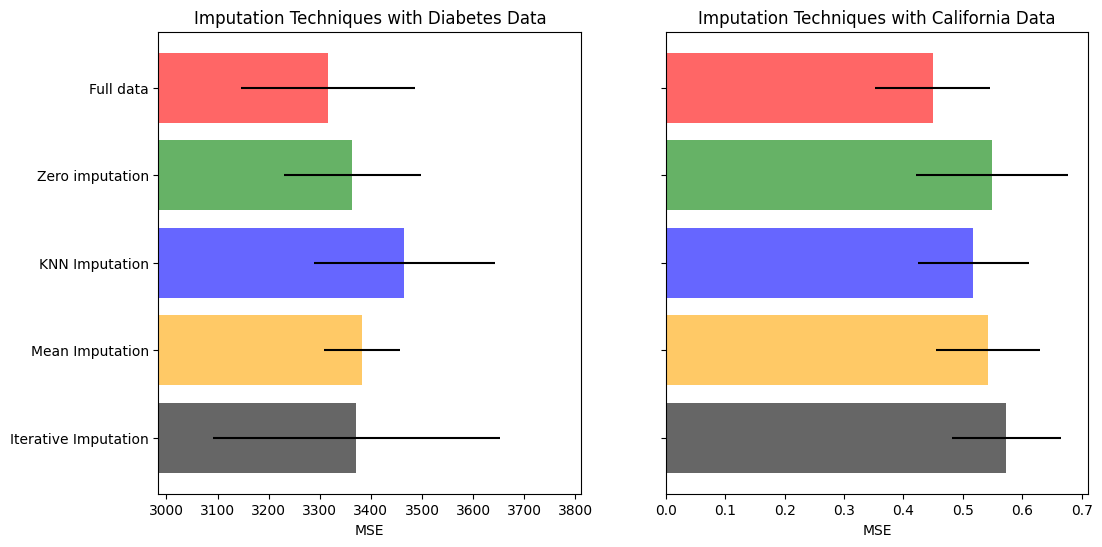

In [81]:
import matplotlib.pyplot as plt

n_bars = len(mses_diabetes)
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange", "black"]

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(
        j,
        mses_diabetes[j],
        xerr=stds_diabetes[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax1.set_title("Imputation Techniques with Diabetes Data")
ax1.set_xlim(left=np.min(mses_diabetes) * 0.9, right=np.max(mses_diabetes) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel("MSE")
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot california dataset results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(
        j,
        mses_california[j],
        xerr=stds_california[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax2.set_title("Imputation Techniques with California Data")
ax2.set_yticks(xval)
ax2.set_xlabel("MSE")
ax2.invert_yaxis()
ax2.set_yticklabels([""] * n_bars)

plt.show()